나는 정직하게 시험에 응할 것을 서약합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
np.random.randn(4)

array([ 0.70619002, -0.14748796, -0.18370756,  0.18200821])

In [3]:
initial = {"h": 2000, "V": 300, "AOA":np.deg2rad(2), "Sideslip": np.deg2rad(0),"yaw_eu":np.deg2rad(80), "pitch_eu":np.deg2rad(20), "roll_eu":np.deg2rad(0), "roll_bo":np.deg2rad(2), "pitch_bo":np.deg2rad(10),"yaw_bo":np.deg2rad(-5) }

In [4]:
print(initial)

{'h': 2000, 'V': 300, 'AOA': 0.03490658503988659, 'Sideslip': 0.0, 'yaw_eu': 1.3962634015954636, 'pitch_eu': 0.3490658503988659, 'roll_eu': 0.0, 'roll_bo': 0.03490658503988659, 'pitch_bo': 0.17453292519943295, 'yaw_bo': -0.08726646259971647}


In [5]:
m = 1000 #kg
l = 8
d = 0.8
S = 0.5
I_xx = 300
I_yy = 19000
I_zz = 21000

In [6]:
Cx_0 = -0.2
Cx_alpha = -2.1
Cx_beta = -1.7
Cy_0 = 0
Cy_beta = -2.3
Cz_0 = -0.02
Cz_alpha = -3.8

In [7]:
Cl_p = -0.01
Cm_0 = 0.02
Cm_alpha = -5
Cm_q = -60
Cn_0 = 0
Cn_beta = 7
Cn_r = -45

# 문제에 주어진 조건 활용

In [8]:
#밀도 계산
def rho(V,h):
  return 1.225 * np.exp(-h/8500)
#동압 계산
def dynamic_inf(V,h):
  return 0.5 * rho(V,h) * V**2
#중력가속도 계산(고도에 따라 바뀜)
def gravity(h):
  Re = 6378.137 * 1000 #m
  return 9.80665 * (Re/(Re + h) )**2
#Calculate X
#이때 C는 calculate의 약자임
def C_X(q_inf , alpha, beta):
  return q_inf * S * ( Cx_0 + Cx_alpha * alpha **2 + Cx_beta * beta**2)

def C_Y(q_inf,beta):
  return q_inf * S * (Cy_0 + Cy_beta * beta)

def C_Z(q_inf,alpha):
  return q_inf * S * (Cz_0 + Cz_alpha * alpha)

def C_L(q_inf,p):
  return q_inf * S * d * Cl_p * p

def C_M(q_inf,alpha,q,V):
  return q_inf * S * d * (Cm_0 + Cm_alpha * alpha  + d/(2*V)*Cm_q*q)

def C_N(q_inf,beta,q,r,V):
  return q_inf * S * d * (Cn_0 + Cn_beta * beta  + d/(2*V)*Cn_r*r)

In [9]:
#수치적분 모델 정의
def model(init,t):
  u,v,w , p,q,r , x,y,h, alpha, beta, yaw, pitch, roll= init
  V = np.sqrt(u**2 + v**2 + w**2)
  q_inf = dynamic_inf(V,h)
  g=  gravity(h)
  X = C_X(q_inf , alpha, beta)
  Y = C_Y(q_inf,beta)
  Z = C_Z(q_inf,alpha)
  L = C_L(q_inf,p)
  M = C_M(q_inf,alpha,q,V)
  N = C_N(q_inf,beta,q,r,V)
  u_dot = 1/m * (X )  - g * np.sin(pitch) + r*v - q*w
  v_dot = 1/m * (Y) + g*np.sin(roll)*np.cos(pitch) + p*w -r*u
  w_dot = 1/m *(Z) + g*np.cos(roll)*np.cos(pitch) + q*u - p*v
  p_dot = (L - (I_zz - I_yy)*q*r) / I_xx
  q_dot = (M -(I_xx - I_zz)*(p*r))/I_yy
  r_dot = (N - (I_yy - I_xx)*(p*q)) / I_zz
  yaw_dot = (q*np.sin(roll) + r * np.cos(roll)) / np.cos(pitch)
  pitch_dot = q*np.cos(roll) - r*np.sin(roll)
  roll_dot = p + (q*np.sin(roll) + r*np.cos(roll)) * np.tan(pitch)
  x_dot = u * np.cos(pitch) * np.cos(yaw) + v*(np.sin(roll)*np.sin(pitch)*np.cos(yaw) - np.cos(roll)*np.sin(yaw)) + w*(np.cos(roll)*np.sin(pitch)*np.cos(yaw) +np.sin(roll)*np.sin(yaw ))
  y_dot =  u * np.cos(pitch) * np.sin(yaw) + v*(np.sin(roll)*np.sin(pitch)*np.sin(yaw) + np.cos(roll)*np.cos(yaw)) + w*(np.cos(roll)*np.sin(pitch)*np.sin(yaw) -np.sin(roll)*np.cos(yaw ))
  h_dot = u*np.sin(pitch) - v*np.sin(roll)*np.cos(pitch) - w*np.cos(pitch)*np.cos(roll)
  V_dot = (u*u_dot + v*v_dot + w*w_dot) / V
  alpha_dot = (u*w_dot -w*u_dot)/ (u**2 + w**2)
  beta_dot = (V*v_dot-v*V_dot)/(V*np.sqrt(u**2 + w**2))
  return np.array([u_dot,v_dot,w_dot,p_dot,q_dot,r_dot,x_dot,y_dot,h_dot,alpha_dot,beta_dot,yaw_dot,pitch_dot,roll_dot])









299.8172481057287 10.469849010750291
[ 2.99817248e+02  0.00000000e+00  1.04698490e+01  3.49065850e-02
  1.74532925e-01 -8.72664626e-02  0.00000000e+00  0.00000000e+00
  2.00000000e+03  3.49065850e-02  0.00000000e+00  1.39626340e+00
  3.49065850e-01  0.00000000e+00]


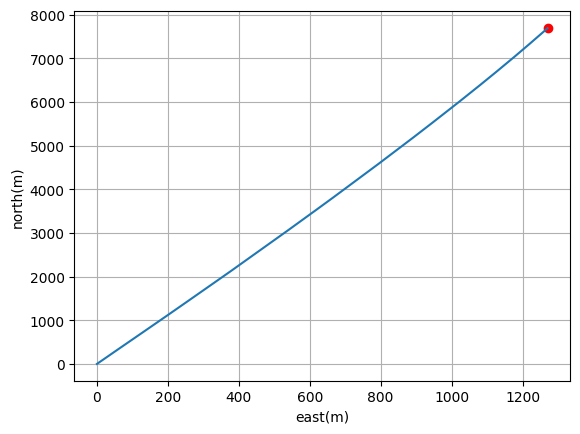

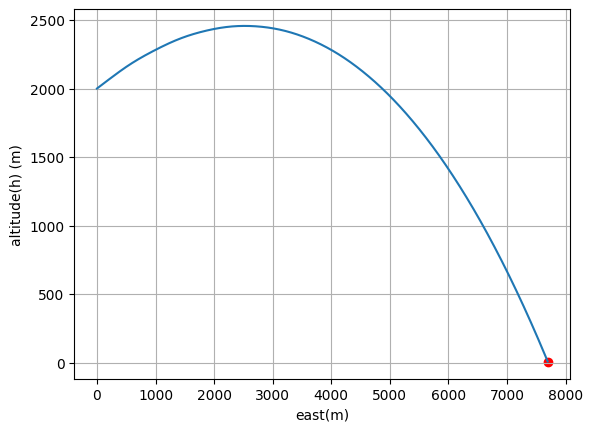

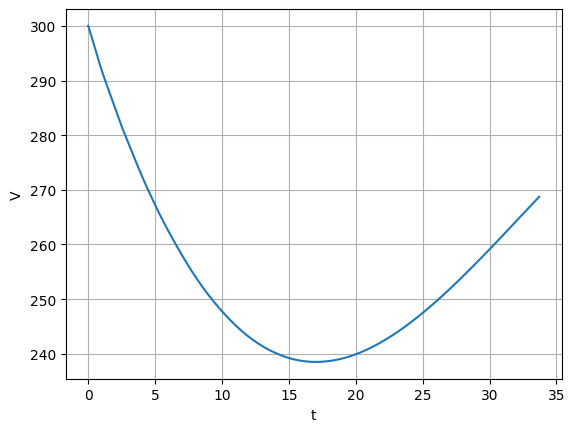

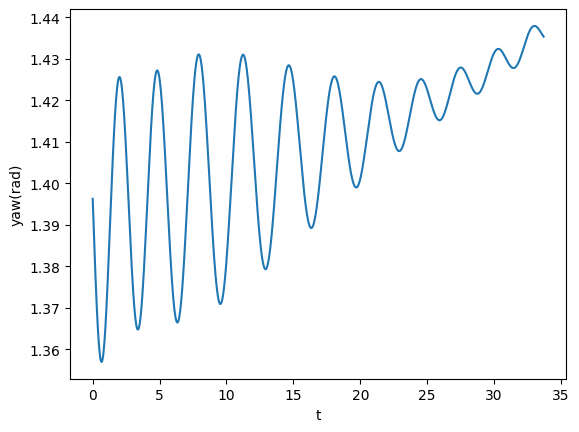

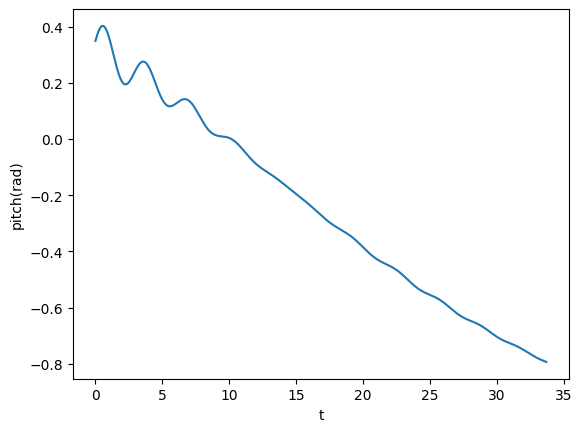

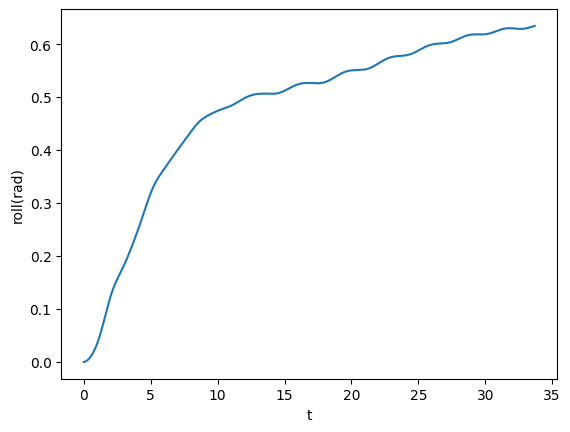

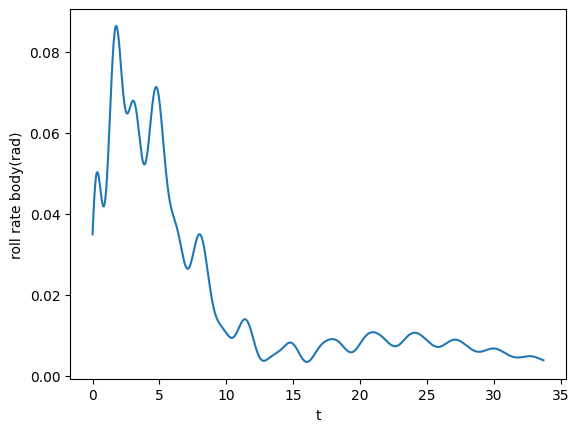

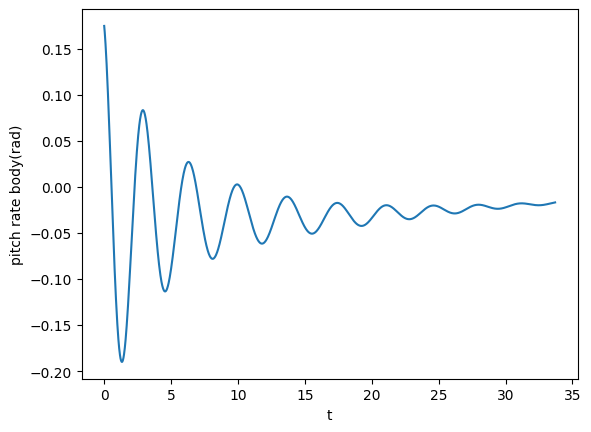

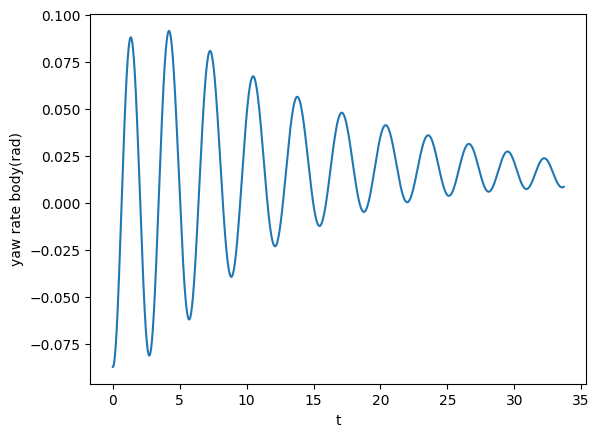

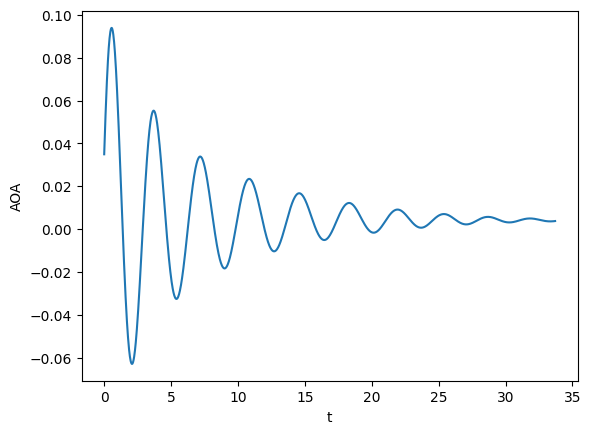

In [16]:
import scipy.integrate as spi
import matplotlib.pyplot as plt
h = 2000
V = 300
alpha = np.deg2rad(2)
beta = 0
yaw = np.deg2rad(80)
pitch = np.deg2rad(20)
roll = 0
p = np.deg2rad(2)
q = np.deg2rad(10)
r = np.deg2rad(-5)
v = np.sin(beta)*V
u = np.sqrt((V**2 - v**2)/((np.tan(alpha))**2+1))
w = u*np.tan(alpha)











print(u,w)
x = 0
y = 0
init = np.array([u,v,w , p,q,r , x,y,h, alpha, beta, yaw, pitch, roll])
print(init)








t = np.linspace(0,2000,100000)
states3_ab = np.zeros((100000,14))
states3_ab[0,:] = init
T = 100000
dt = t[1]-t[0]
deriv_p = model(init,t)
last = 0
#I use Adams–Bashforth method which is found in https://nbviewer.org/gist/jonghank/54bcb837296a6fb5e64a475cd440261d



for k in range(T-1):
  deriv = model(states3_ab[k,:],t[k])
  next = states3_ab[k,:] + 0.5*dt*(3*deriv - deriv_p)
  if next[8]>=0:
    states3_ab[k+1,:] = next
    deriv_p = deriv
    last = k
  else:
    break

#problem1
plt.plot(states3_ab[:last,6], states3_ab[:last,7])
plt.scatter(states3_ab[last,6], states3_ab[last,7],color = "red")
plt.xlabel("east(m)")
plt.ylabel("north(m)")
plt.grid()
plt.show()
plt.plot(states3_ab[:last,7], states3_ab[:last,8])
plt.xlabel("east(m)")
plt.ylabel("altitude(h) (m)")
plt.grid()
plt.scatter(states3_ab[last,7], states3_ab[last,8],color = "red")
plt.show()
plt.plot(t[:last],np.sqrt(states3_ab[:last,0]**2 + states3_ab[:last,1]**2 + states3_ab[:last,2]**2 ))
plt.xlabel("t")
plt.ylabel("V")
plt.grid()
plt.show()
plt.xlabel("t")
plt.ylabel("yaw(rad)")
plt.plot(t[:last],states3_ab[:last,-3])
plt.show()
plt.xlabel("t")
plt.ylabel("pitch(rad)")
plt.plot(t[:last],states3_ab[:last,-2])
plt.show()
plt.xlabel("t")
plt.ylabel("roll(rad)")
plt.plot(t[:last],states3_ab[:last,-1])
plt.show()
plt.xlabel("t")
plt.ylabel("roll rate body(rad)")
plt.plot(t[:last],states3_ab[:last,3])
plt.show()
plt.xlabel("t")
plt.ylabel("pitch rate body(rad)")
plt.plot(t[:last],states3_ab[:last,4])
plt.show()
plt.xlabel("t")
plt.ylabel("yaw rate body(rad)")
plt.plot(t[:last],states3_ab[:last,5])
plt.show()
plt.xlabel("t")
plt.ylabel("AOA")
plt.plot(t[:last],states3_ab[:last,9])
plt.show()






In [11]:
#problem b
print(f"east:{states3_ab[last,6]} m , north:{states3_ab[last,7]} m")

east:1271.4952134462155 m , north:7697.750314811598 m


In [12]:
#problem c
print(f"min speed V is {np.min(  np.sqrt(states3_ab[:last,0]**2 + states3_ab[:last,1]**2 + states3_ab[:last,2]**2 )) } m/s")

min speed V is 238.51090998128277 m/s


1.5137579239503982
1.5137579239503982
{8.504905511676068: 0, 6.512527857706172: 1, 3.061475964915394: 2, 2.0243385072974616: 3, 1.5137579239503982: 4}


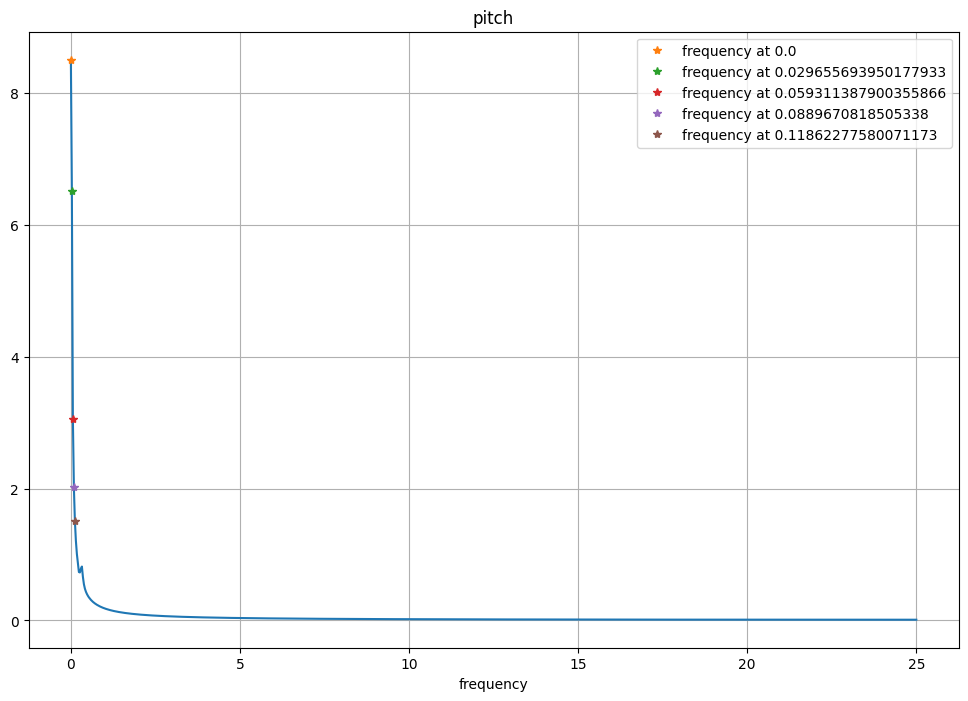

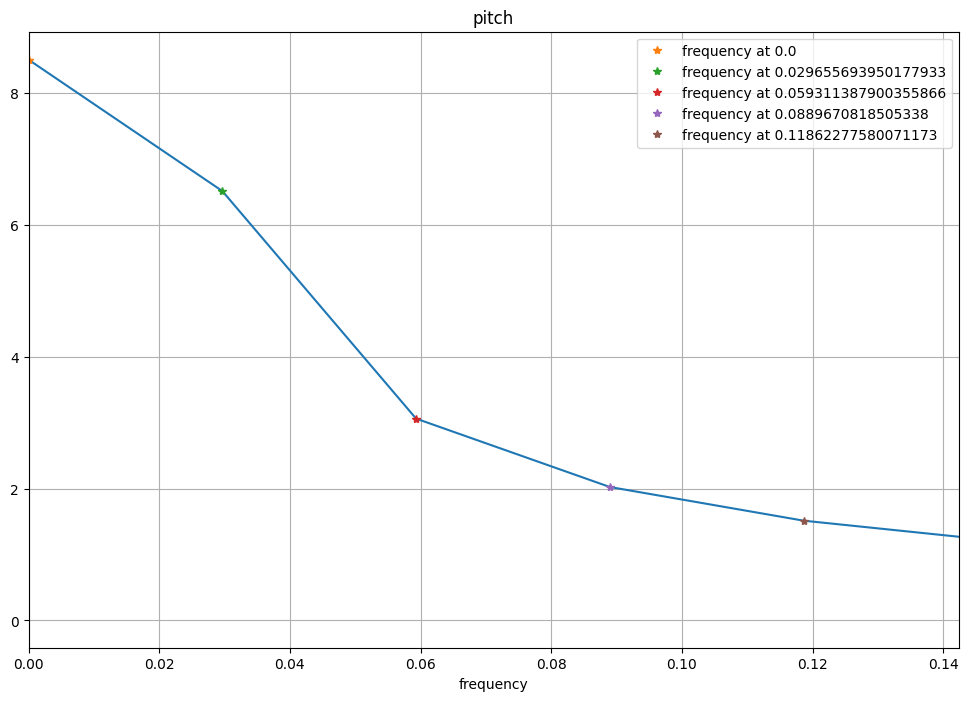

0.1531182421581422


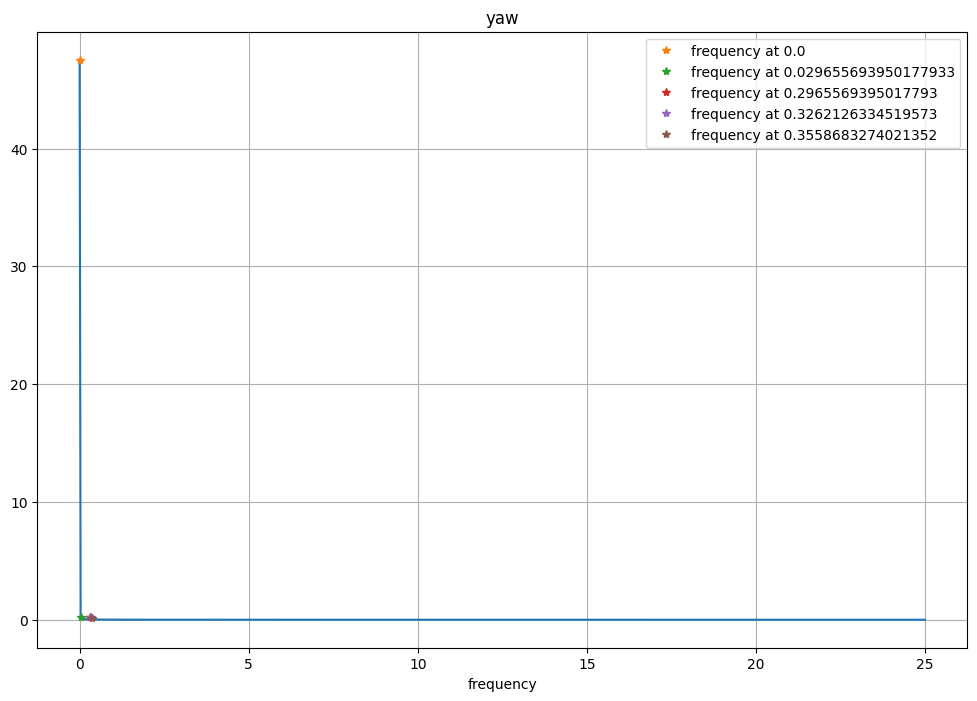

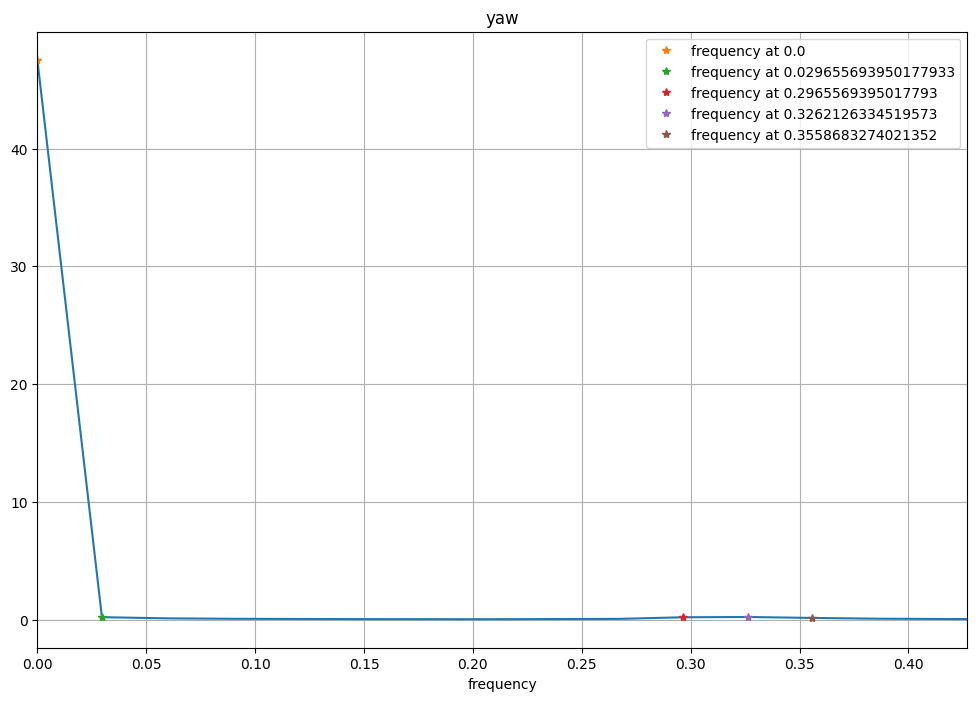

In [13]:
#problem d


#we can use fft
def fft_st_ed(start, end, mono, dt, dominant_num: int):
    x_1 = mono[start:end]
    N = len(x_1)
    fs = 1/dt
    df = fs / N
    f = np.arange(0, N) * df
    X_1 = np.fft.fft(x_1) * dt
    X_1_rec = X_1[0:int(len(X_1) / 2) + 1]
    S = set(sorted(np.abs(X_1_rec.copy()), reverse=True)[:dominant_num])
    result = {}
    for i in range(len(np.abs(X_1_rec))):
        if np.abs(X_1_rec)[i] in S:
            result[np.abs(X_1_rec)[i]] = i


    min_in_max = sorted(result.items())[0][0]
    print(min_in_max)
    X_recon = X_1.copy()
    X_recon[np.abs(X_recon) < min_in_max] = 0
    x_recon = np.fft.ifft(X_recon).real * fs
    return x_1, x_recon, result, X_1, X_recon





#plot goverment frequency
def plot_fft_frec(x_1,X_1,X_recon,result,dt,is_graph_lim_x,jaemok):
  N = len(x_1)
  fs = 1/dt
  df = fs/N
  f = np.arange(0,N)*df
  plt.figure(figsize = (12,8))
  plt.plot(f[0:int(N/2)+1],np.abs(X_1)[0:int(N/2) + 1])
  for i in result:
    plt.plot(f[result[i]],np.abs(X_recon)[result[i]],"*",label = f"frequency at {f[result[i]]}" )
  plt.legend()
  max_mag = max(result,key=result.get)
  min_mag = min(result,key=result.get)
  plt.xlabel("frequency")
  plt.ylabel("")
  if is_graph_lim_x:
    plt.title(jaemok)
    plt.xlim([0.7*f[result[min_mag]],1.2*f[result[max_mag]]])
    plt.grid()
    plt.show()
  else:
    plt.title(jaemok)
    plt.grid()
    plt.show()


start = 0
end = last
dominant_num = 5
x_1, x_recon,result,X_1,X_recon =  fft_st_ed(start,end,states3_ab[:last,-2],dt,dominant_num)
print(min(result))
print(result)
plot_fft_frec(x_1,X_1,X_recon,result,dt,False, "pitch")
plot_fft_frec(x_1,X_1,X_recon,result,dt,True, "pitch")
x_1, x_recon,result,X_1,X_recon =  fft_st_ed(start,end,states3_ab[:last,-3],dt,dominant_num)
plot_fft_frec(x_1,X_1,X_recon,result,dt,False,"yaw")
plot_fft_frec(x_1,X_1,X_recon,result,dt,True,"yaw")

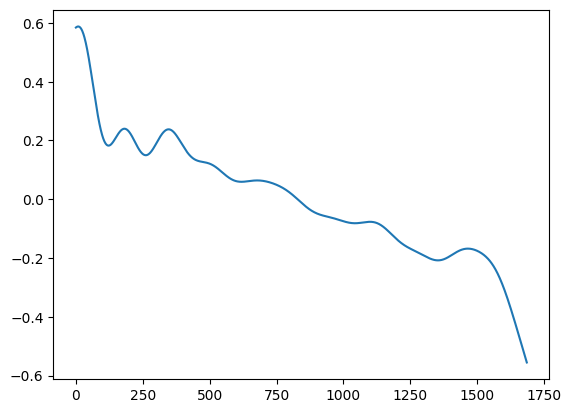

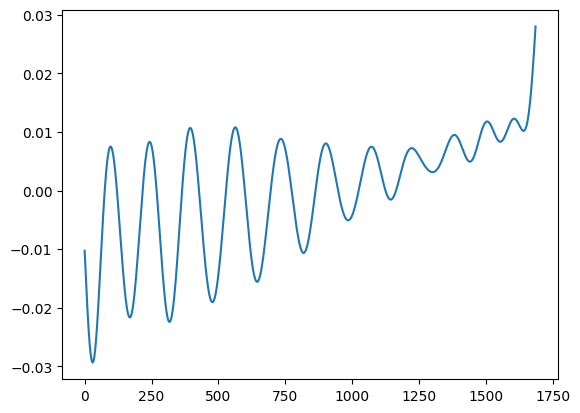

In [30]:
def fft_threshold(start, end, mono, dt,threshold,is_bigger):
    fs=  1/dt
    x_1 = mono[start :end ]
    N = len(x_1)
    dt = 1 / fs
    X_1 = np.fft.fft(x_1) * dt
    df = fs / N
    f = np.arange(0, N) * df
    X_recon = X_1.copy()
    if is_bigger==">":
      X_recon[np.abs(f) > threshold] = 0
      x_recon = np.fft.ifft(X_recon).real * fs
    else:
      X_recon[np.abs(f) < threshold] = 0
      x_recon = np.fft.ifft(X_recon).real * fs
    return x_recon, X_recon


x_recon_1, X_recon_1 = fft_threshold(0,last,states3_ab[:last,-2],dt,0.13,"<")
plt.plot(x_recon_1)
plt.show()
x_recon_1, X_recon_1 = fft_threshold(0,last,states3_ab[:last,-3],dt,0.5,"<")
plt.plot(x_recon_1)
plt.show()